In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from emb_utils import EmbeddingIndex

In [2]:
data = pd.read_csv("data/web-redditEmbeddings-subreddits.csv", header=0)
subreddit_name = data.iloc[:,0].to_numpy()
embeddings     = data.iloc[:, 1:].to_numpy()

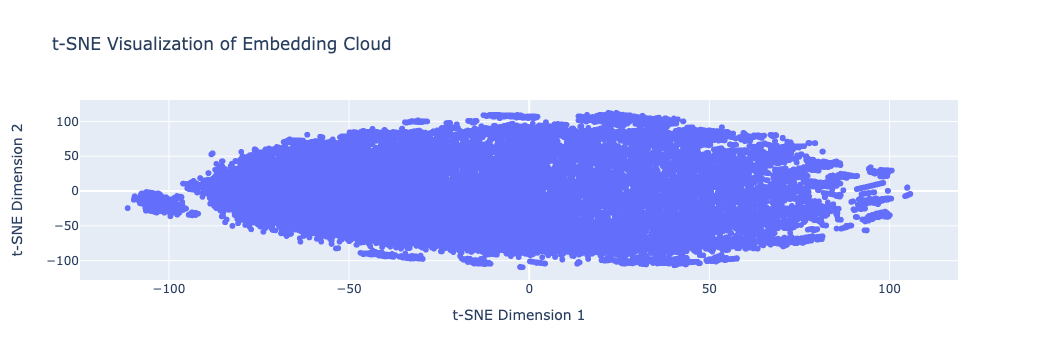

In [5]:
def visualize_embedding_cloud(embeddings, names, perplexity=10, random_seed=20):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_seed)
    embeddings_2d = tsne.fit_transform(embeddings)
    fig = px.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hover_name=list(names),
                     title="t-SNE Visualization of Embedding Cloud",
                     labels={'x': 't-SNE Dimension 1', 'y': 't-SNE Dimension 2'})
    fig.show()

idx = np.arange(embeddings.shape[0])
visualize_embedding_cloud(embeddings[idx,:], subreddit_name[idx])

In [9]:
index_flatL2 = EmbeddingIndex(dimension=embeddings.shape[1], index_params={'type': 'FlatL2'})
index_flatL2.add_embeddings(embeddings, metadata=subreddit_name.tolist())
index_flatL2.save_index('data/flatL2_index')

In [3]:
index_flatL2 = EmbeddingIndex(dimension=embeddings.shape[1], index_params={'type': 'FlatL2'})
index_flatL2.load_index('data/flatL2_index')    

In [4]:
assert index_flatL2.index.ntotal == embeddings.shape[0] and embeddings.shape[0] == subreddit_name.shape[0]

In [6]:
index_HNSW = EmbeddingIndex(embeddings.shape[1], {'index_type': 'HNSWFlat'})
index_HNSW.add_embeddings(embeddings, metadata=subreddit_name.tolist())
index_HNSW.save_index('data/HNSW_index')

In [18]:
index_LSH = EmbeddingIndex(embeddings.shape[1], {'index_type': 'LSH'})
index_LSH.add_embeddings(embeddings, metadata=subreddit_name.tolist())
index_LSH.save_index('data/LSH_index')

In [15]:
def precision(candidate_index, ground_truth_index, k, queries):
    _, results, _ = candidate_index.search(queries, k)
    _, ground_truth, _ = ground_truth_index.search(queries, k)

    return np.sum(np.sort(results, axis=1) == np.sort(ground_truth, axis=1), axis=1).mean() / k

In [20]:
precision(index_LSH, index_flatL2, 1000, np.random.randn(100,300))

1.0

In [27]:
q = 113
_, _, results = index_HNSW.search(embeddings[q:q+1, :], k=15)
print(subreddit_name[q], results)

sneakers ['sneakers', 'streetwear', 'sneakermarket', 'repsneakers', 'fashionreps', 'supremeclothing', 'kanye', 'frankocean', 'kicksmarket', 'makinghiphop', 'malefashionadvice', 'malefashionmarket', 'donaldglover', 'hiphopcirclejerk', 'rawdenim']
